In [1]:
import re
import unicodedata
import pandas as pd
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import prepare
import acquire
import env

1. Spam Data

- Load the spam data set.

In [2]:
def get_spam_data():
    url = env.get_db_url('spam_db')
    sql = "SELECT * FROM spam"

    df = pd.read_sql(sql, url, index_col="id")
    return df

In [3]:
df = get_spam_data()

In [4]:
df

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."


In [5]:
def clean_data(text):
    ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [6]:
ham_corpus = clean_data(' '.join(df[df.label == 'ham'].text))
spam_corpus = clean_data(' '.join(df[df.label == 'spam'].text))
all_corpus = clean_data(' '.join(df.text))

In [7]:
ham_freq = pd.Series(ham_corpus).value_counts()
spam_freq = pd.Series(spam_corpus).value_counts()
all_freq = pd.Series(all_corpus).value_counts()

In [8]:
all_freq

call             600
im               462
get              397
ur               384
go               304
                ... 
cage               1
surrounded         1
cuck               1
weeddeficient      1
bitching           1
Length: 8900, dtype: int64

In [37]:
spam_freq.nlargest(20)

call       359
free       216
txt        150
ur         144
text       137
mobile     135
4          119
claim      115
stop       113
reply      102
prize       94
get         83
tone        73
service     72
new         69
send        67
nokia       65
urgent      63
week        62
cash        62
dtype: int64

In [36]:
ham_freq.nlargest(20)

im      449
get     314
go      273
ok      272
dont    257
come    242
know    241
call    241
ur      240
ill     236
like    232
got     231
good    223
day     214
time    213
love    193
want    183
need    171
one     170
4       168
dtype: int64

- Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [9]:
def make_bigrams(s, n = 2):
    return (pd.Series(nltk.ngrams(s, n))).value_counts()

make_bigrams(ham_corpus)

(call, later)     52
(ill, call)       48
(let, know)       42
(sorry, ill)      39
(dont, know)      32
                  ..
(cant, ever)       1
(master, cant)     1
(dont, master)     1
(biro, dont)       1
(true, name)       1
Length: 30869, dtype: int64

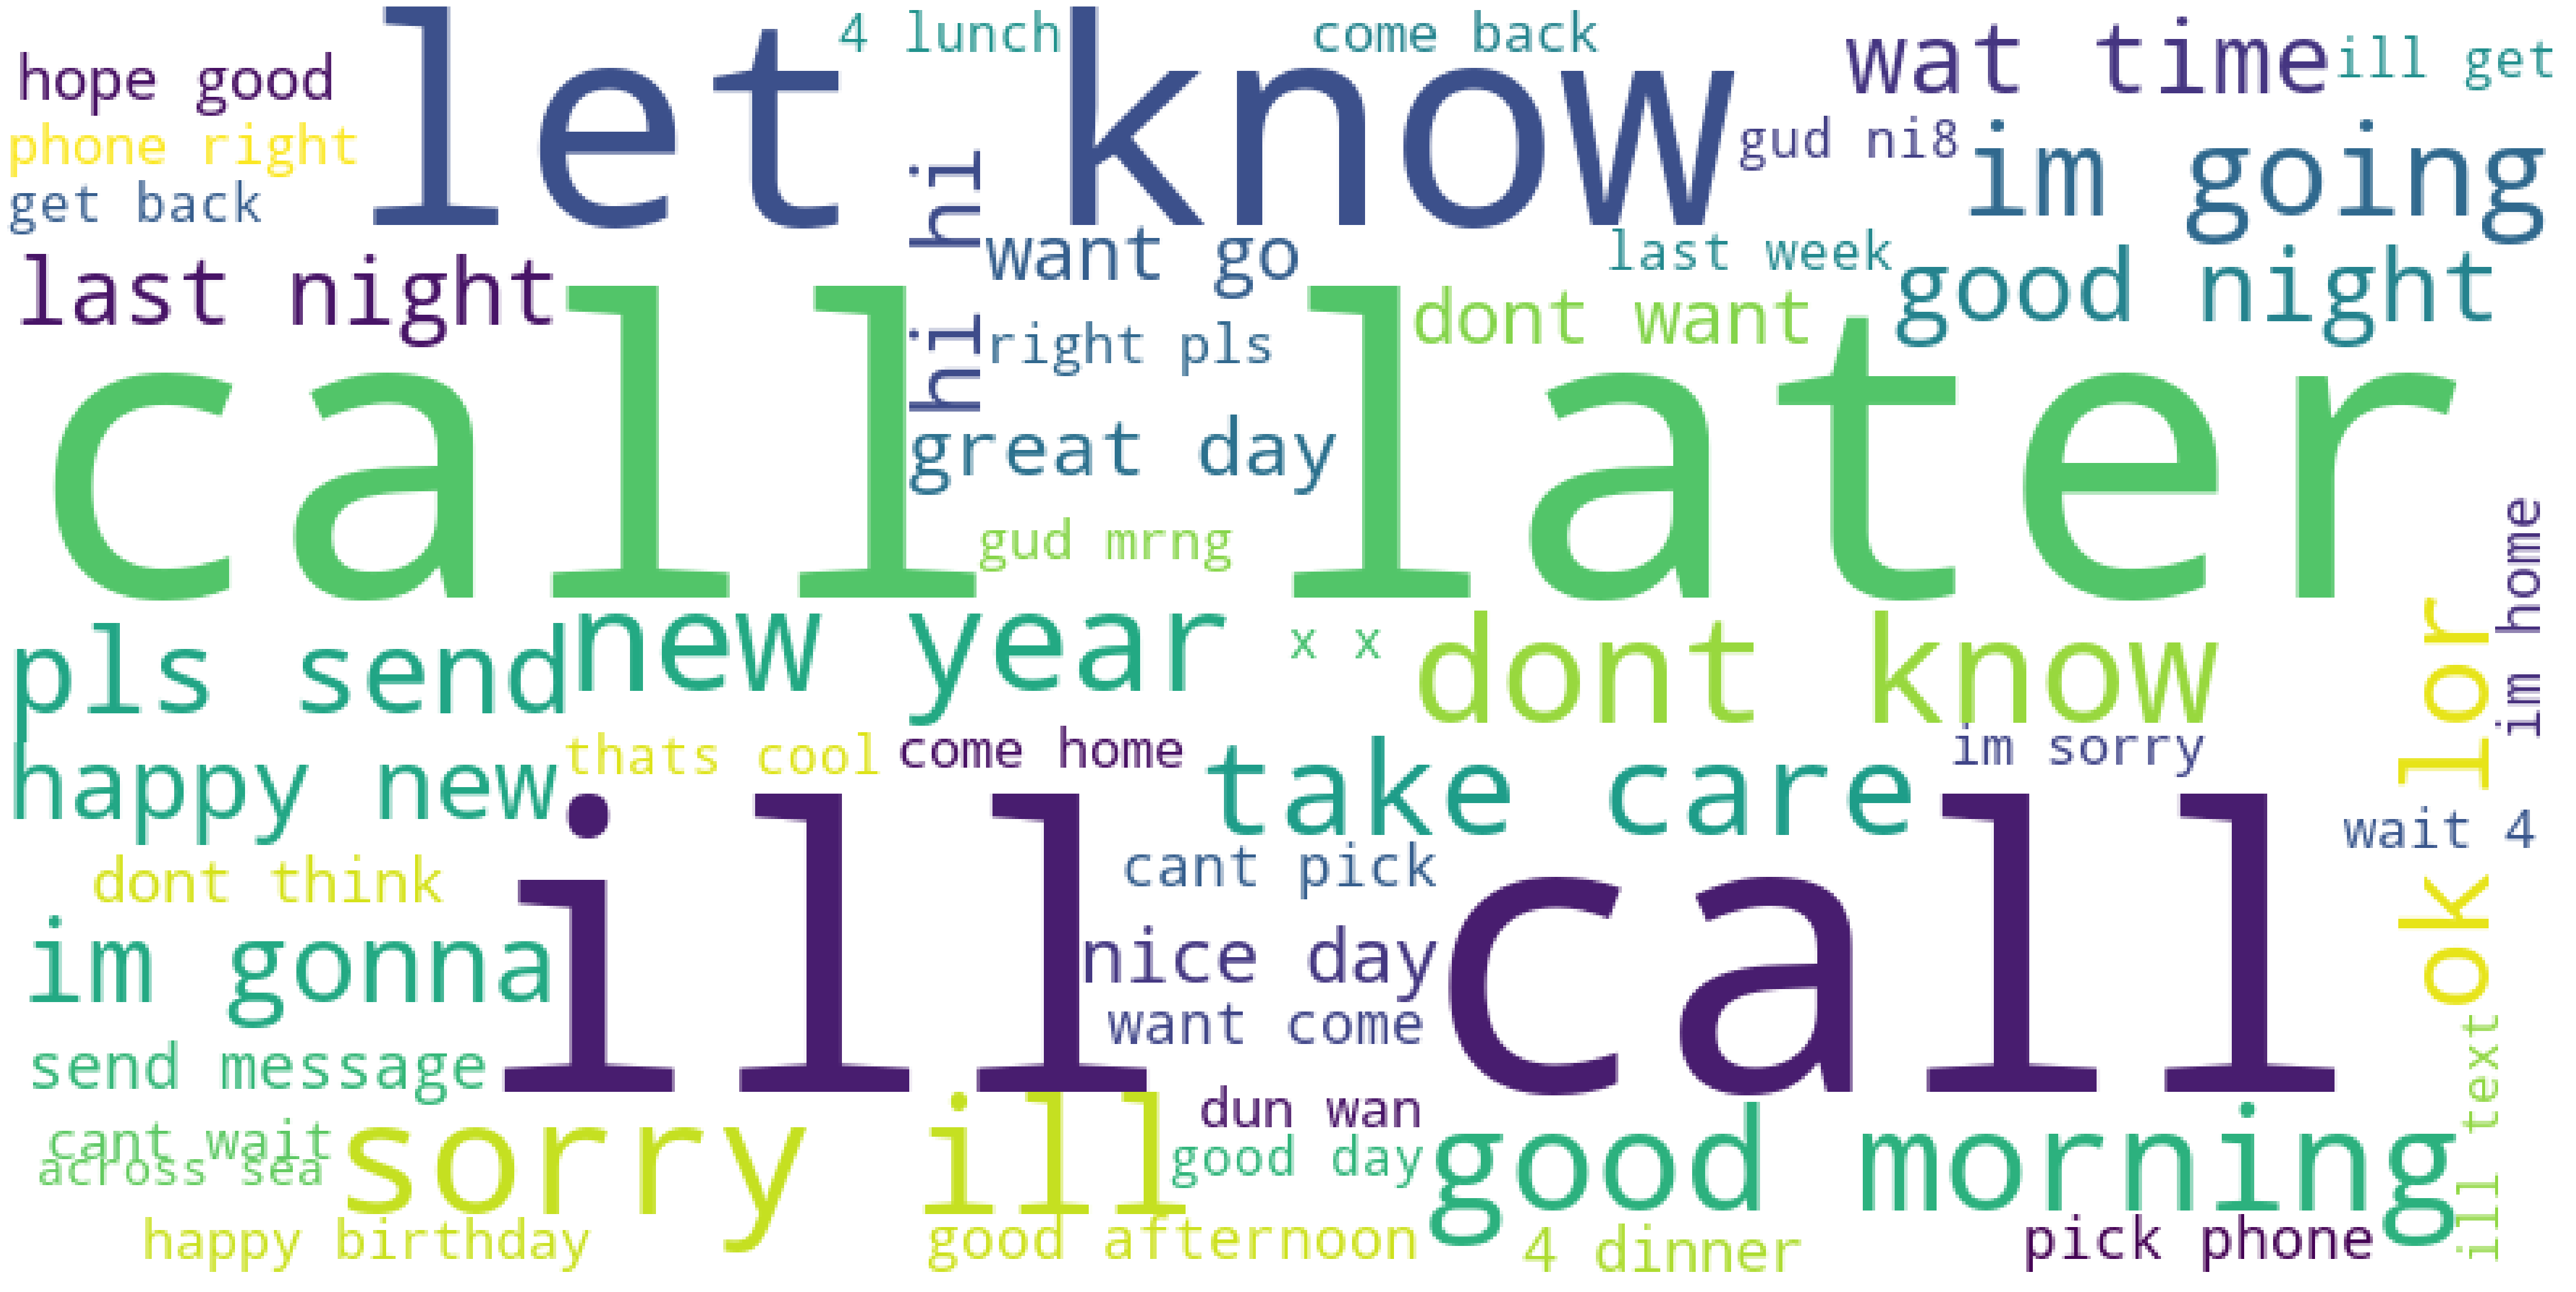

In [10]:
def make_bigram_cloud(s, top = 20, width = 800, height = 400):
    """ s = series of bigram count """
    data = {' '.join(k) : v for k, v in s.nlargest(top).to_dict().items()}
    img = WordCloud(background_color = 'white', width = width, height = height).generate_from_frequencies(data)
    plt.figure(figsize=(width/10, height/10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

make_bigram_cloud(make_bigrams(ham_corpus), top = 50)

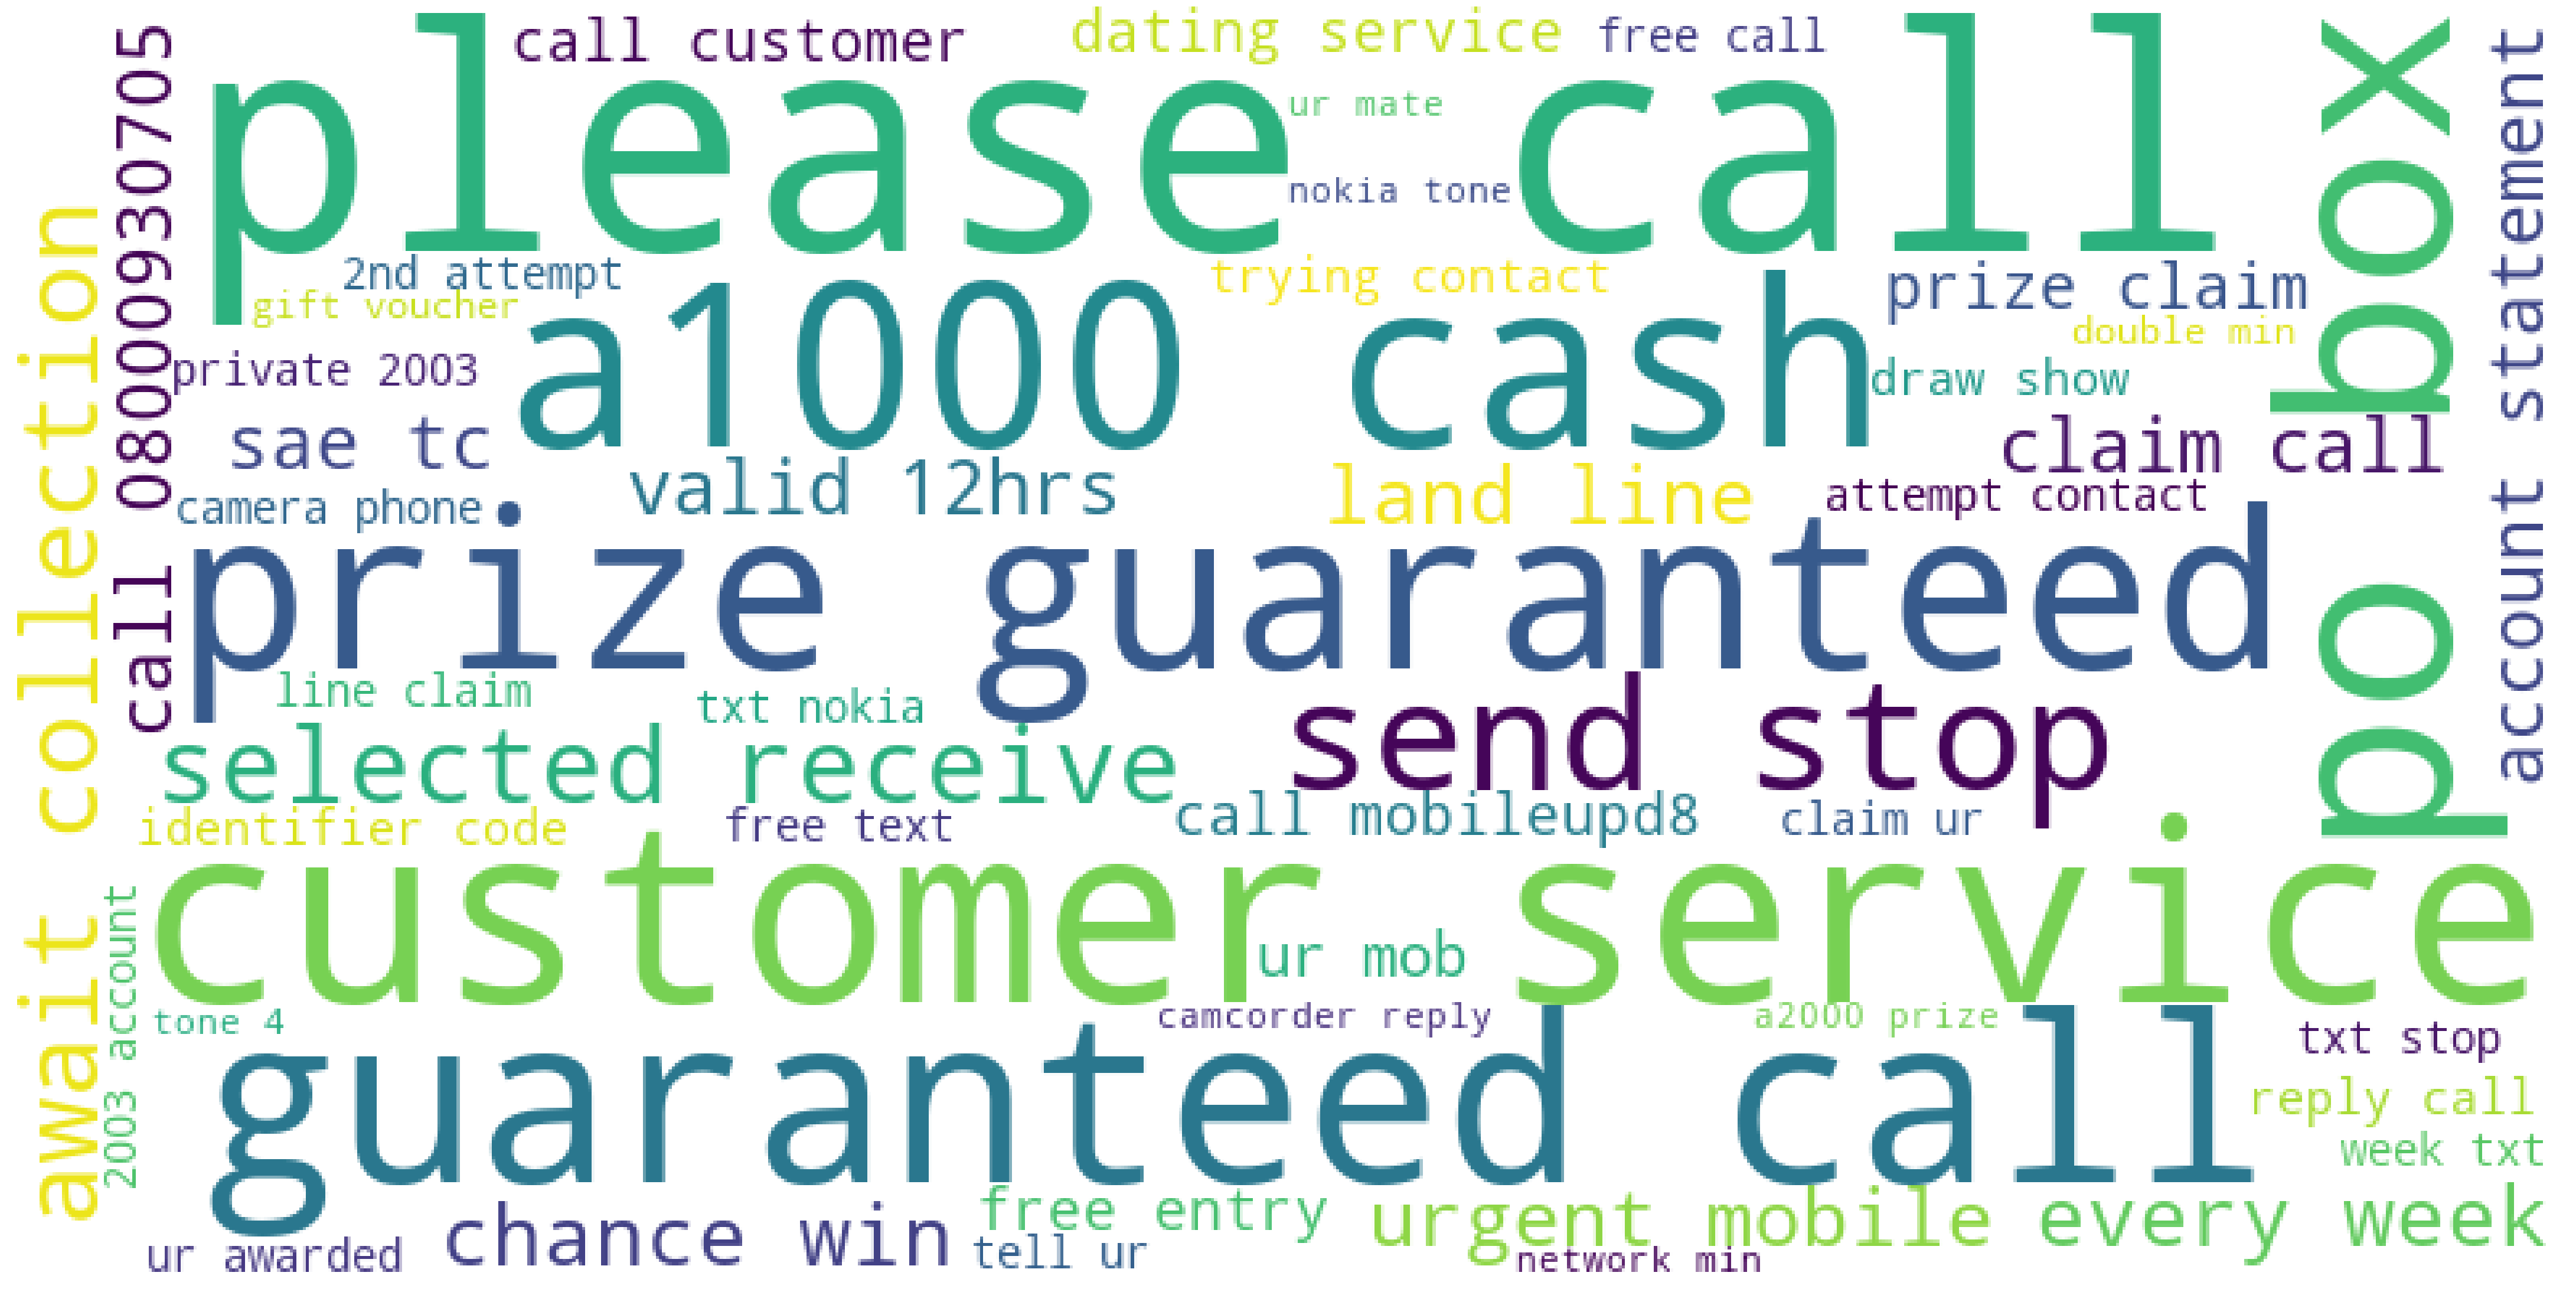

In [11]:
make_bigram_cloud(make_bigrams(spam_corpus), top = 50)

- Is there any overlap in the bigrams for the spam data and the ham data?

In [12]:
all_corpus_bigrams = pd.DataFrame({'all_corpus':make_bigrams(all_corpus)})
ham_corpus_bigrams = pd.DataFrame({'ham_corpus':make_bigrams(ham_corpus)})
spam_corpus_bigrams = pd.DataFrame({'spam_corpus':make_bigrams(spam_corpus)})

In [13]:
all_and_ham = all_corpus_bigrams.join(ham_corpus_bigrams, how = 'left')
bigram_counts = all_and_ham.join(spam_corpus_bigrams, how='left').fillna(0)

In [14]:
#183 of the bigrams overlap
bigram_counts[(bigram_counts.ham_corpus != 0) & (bigram_counts.spam_corpus != 0)]

,all_corpus,ham_corpus,spam_corpus
"(please, call)",53,9.0,44.0
"(dont, know)",38,32.0,6.0
"(new, year)",32,30.0,2.0
"(customer, service)",29,2.0,27.0
"(po, box)",25,1.0,24.0
...,...,...,...
"(next, month)",2,1.0,1.0
"(could, meet)",2,1.0,1.0
"(today, ur)",2,1.0,1.0
"(tomorrow, ur)",1,1.0,1.0


- Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [15]:
def make_compare_df(n_gram = 3):
    ham_corpus = clean_data(' '.join(df[df.label == 'ham'].text))
    spam_corpus = clean_data(' '.join(df[df.label == 'spam'].text))
    all_corpus = clean_data(' '.join(df.text))
    all_corpus_ngrams = pd.DataFrame({'all_corpus':make_bigrams(all_corpus, n = n_gram)})
    ham_corpus_ngrams = pd.DataFrame({'ham_corpus':make_bigrams(ham_corpus, n = n_gram)})
    spam_corpus_ngrams = pd.DataFrame({'spam_corpus':make_bigrams(spam_corpus, n = n_gram)})
    all_and_ham = all_corpus_ngrams.join(ham_corpus_ngrams, how = 'left')
    ngram_counts = all_and_ham.join(spam_corpus_ngrams, how='left').fillna(0)
    return ngram_counts

def find_overlap(df):
    return df[(df.ham_corpus != 0) & (df.spam_corpus != 0)]

def make_barchart(df):
    sns.countplot(x=df.index)

In [16]:
make_compare_df(n_gram=3)

,all_corpus,ham_corpus,spam_corpus
"(ill, call, later)",42,42.0,0.0
"(sorry, ill, call)",38,38.0,0.0
"(prize, guaranteed, call)",21,0.0,21.0
"(happy, new, year)",19,19.0,0.0
"(call, customer, service)",15,0.0,15.0
...,...,...,...
"(bed, throw, laundry)",1,1.0,0.0
"(throw, laundry, top)",1,1.0,0.0
"(laundry, top, cant)",1,1.0,0.0
"(top, cant, friend)",1,1.0,0.0


In [17]:
find_overlap(make_compare_df(n_gram=3))

,all_corpus,ham_corpus,spam_corpus
"(please, call, back)",5,1.0,4.0
"(sorry, missed, call)",3,2.0,1.0
"(number, im, glad)",2,1.0,1.0
"(new, year, eve)",2,1.0,1.0
"(called, left, message)",2,1.0,1.0


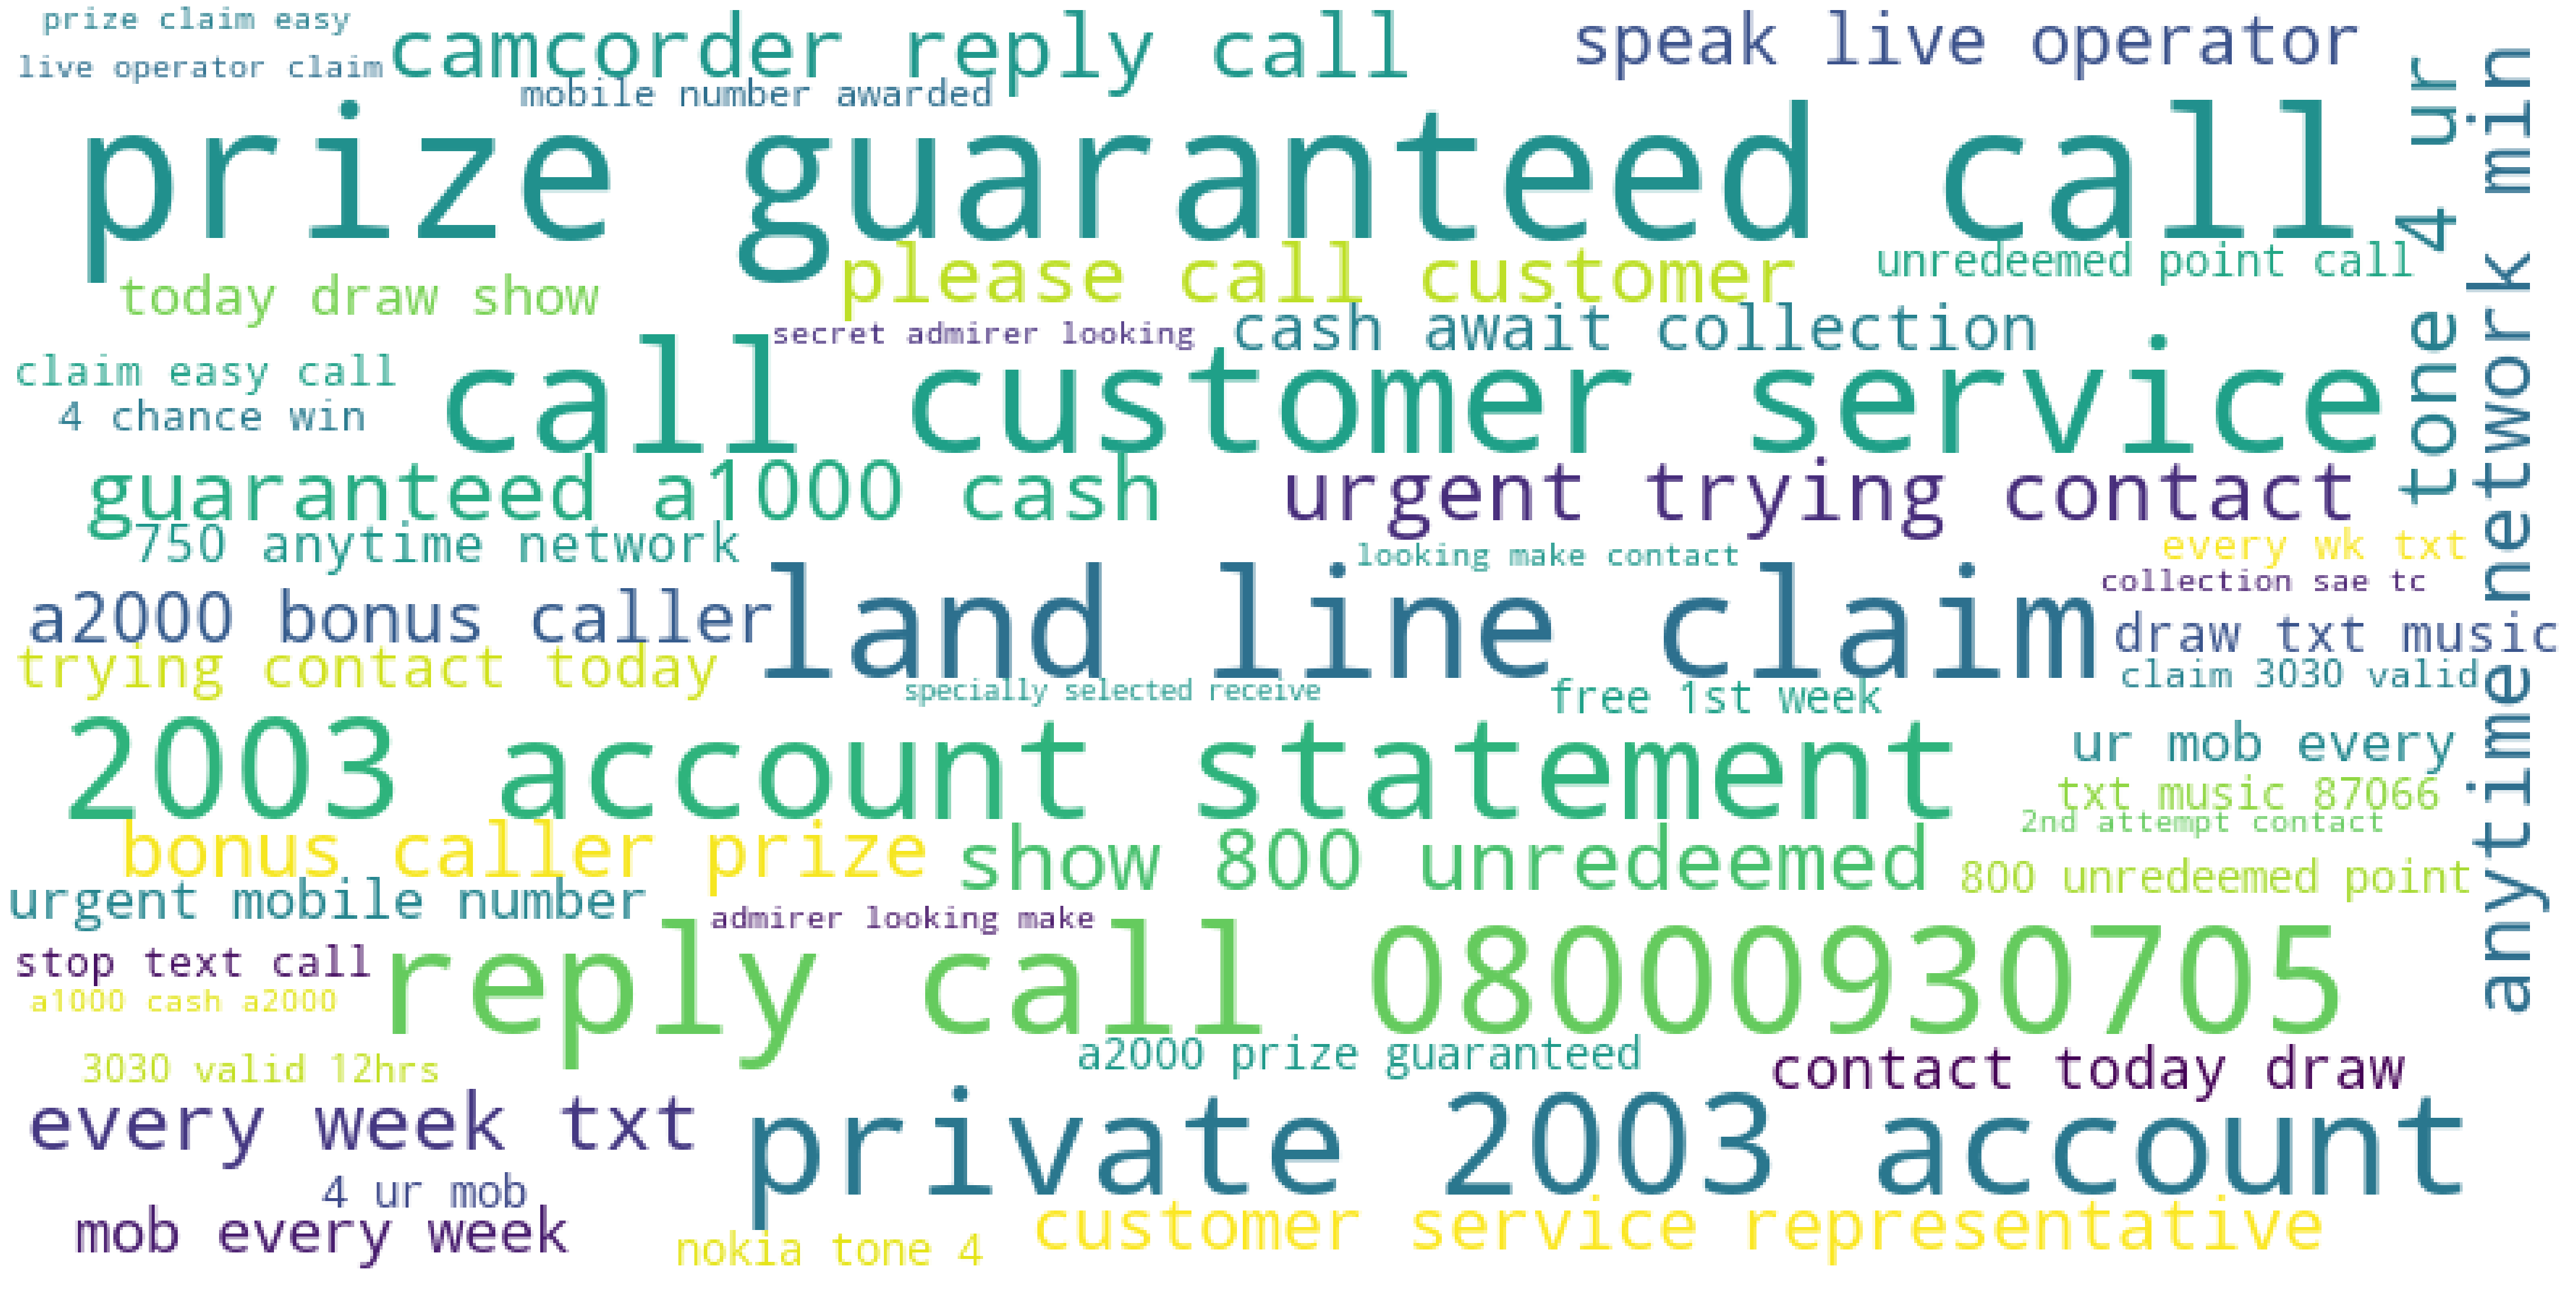

In [18]:
make_bigram_cloud(make_bigrams(spam_corpus, n = 3), top = 50)

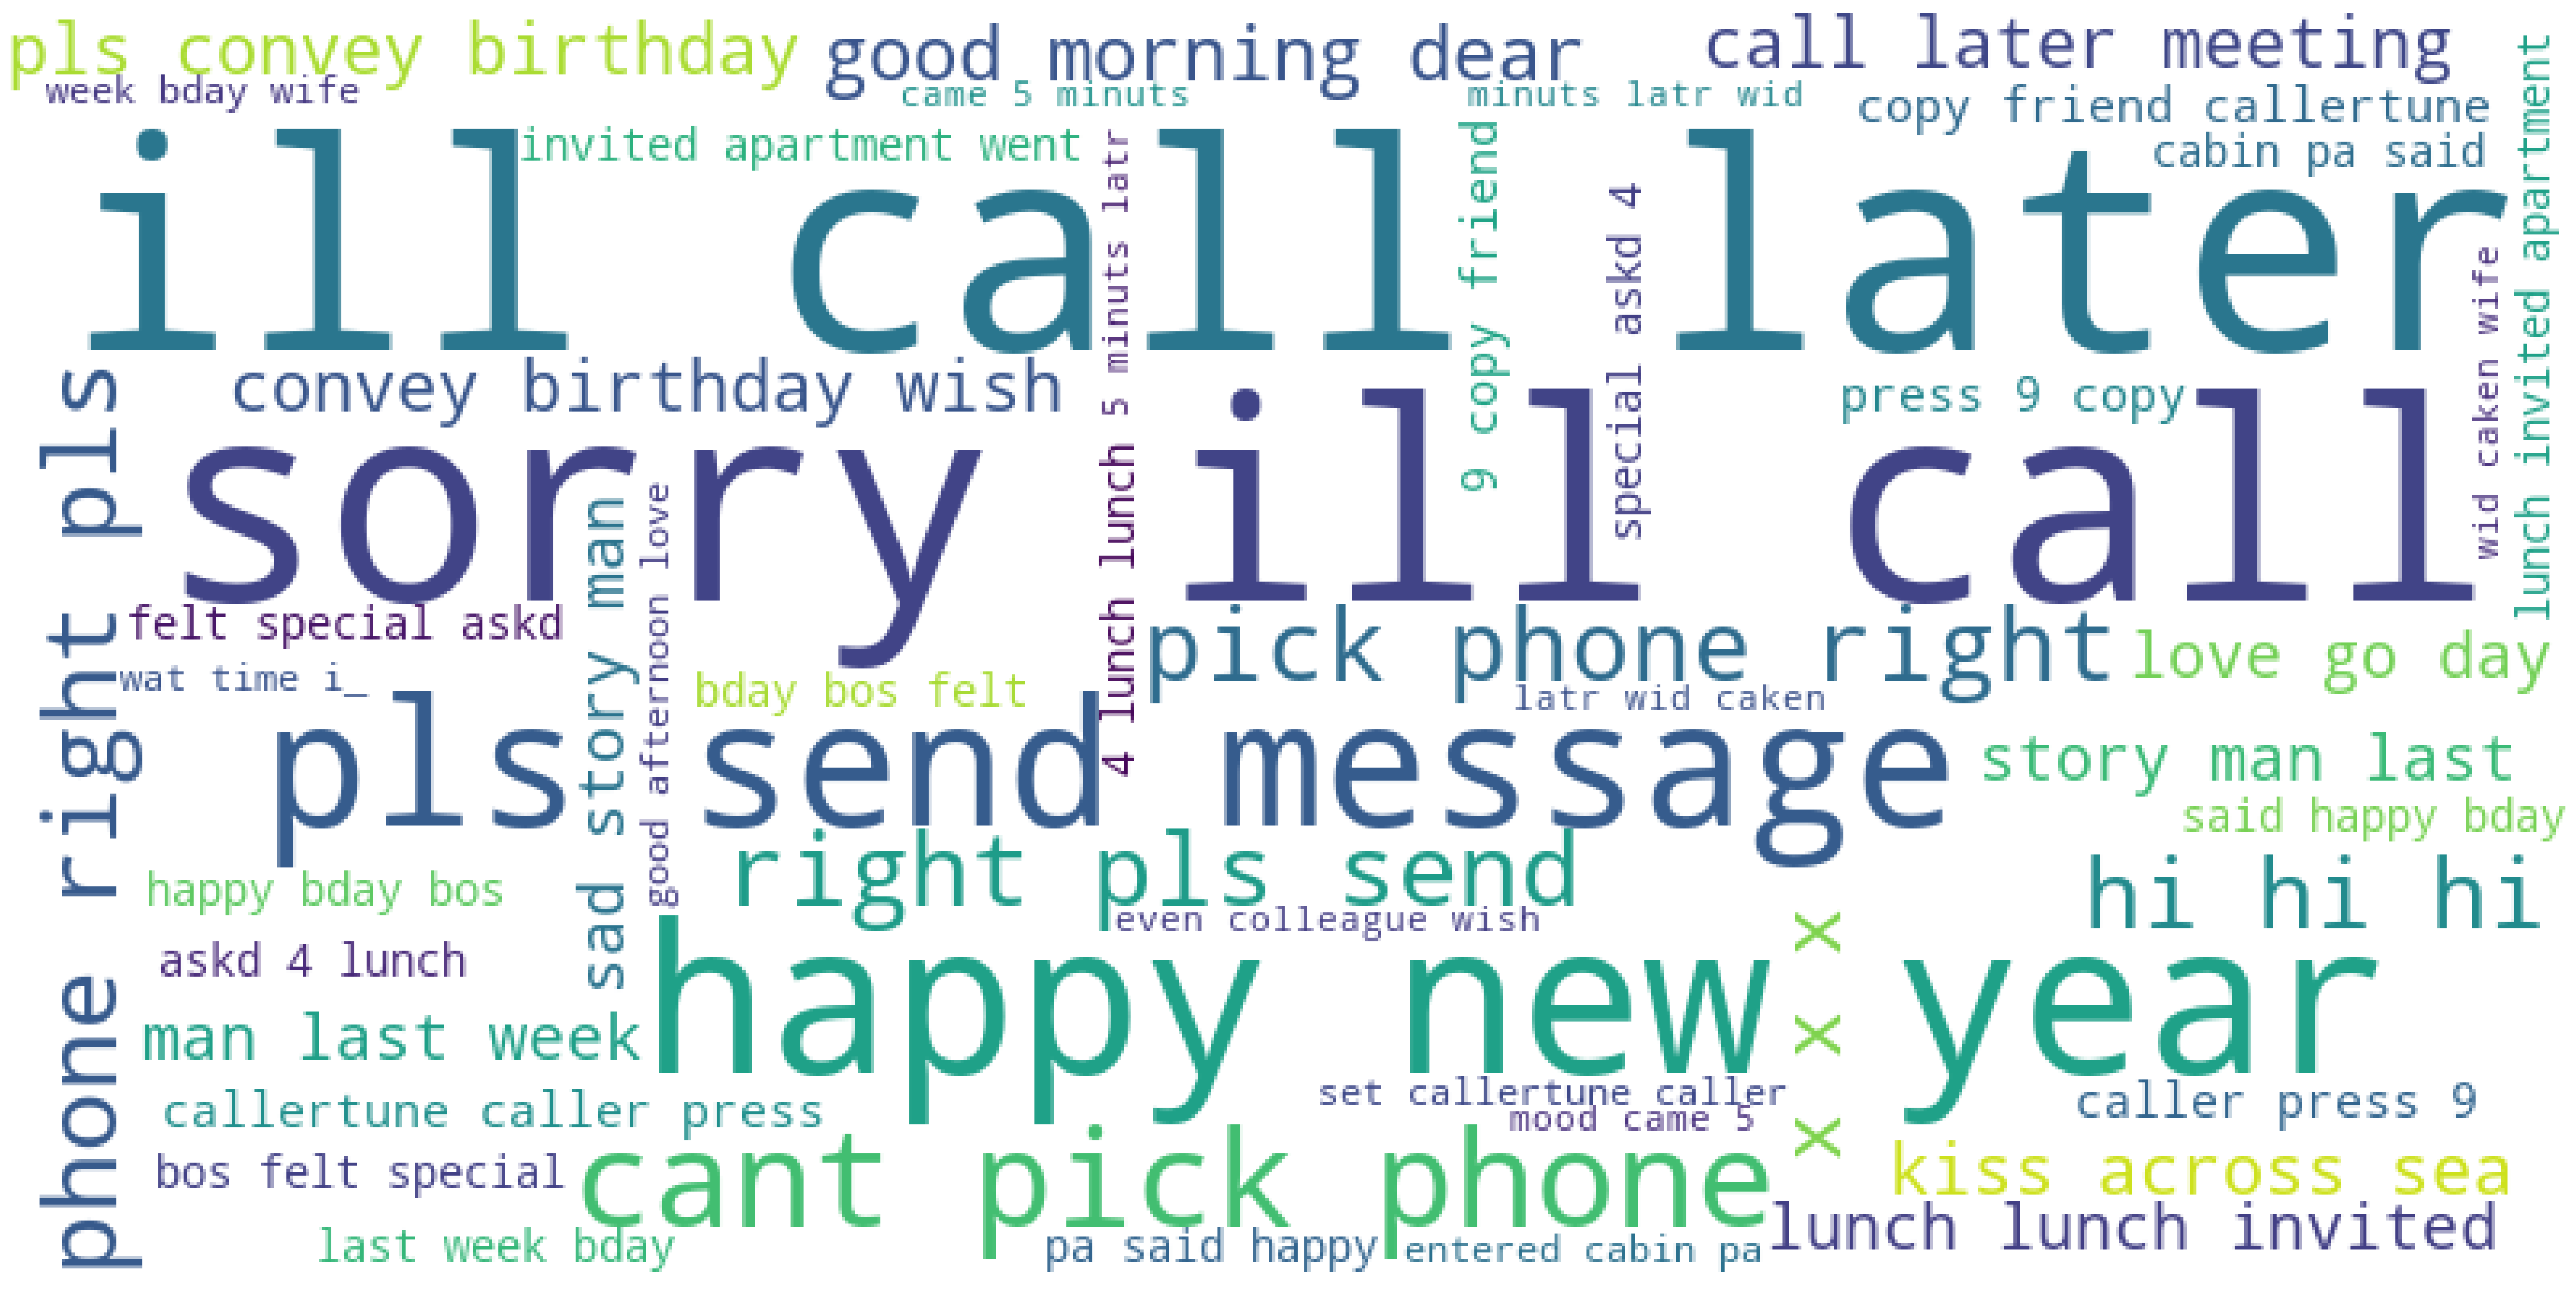

In [19]:
make_bigram_cloud(make_bigrams(ham_corpus, n = 3), top = 50)

<AxesSubplot:>

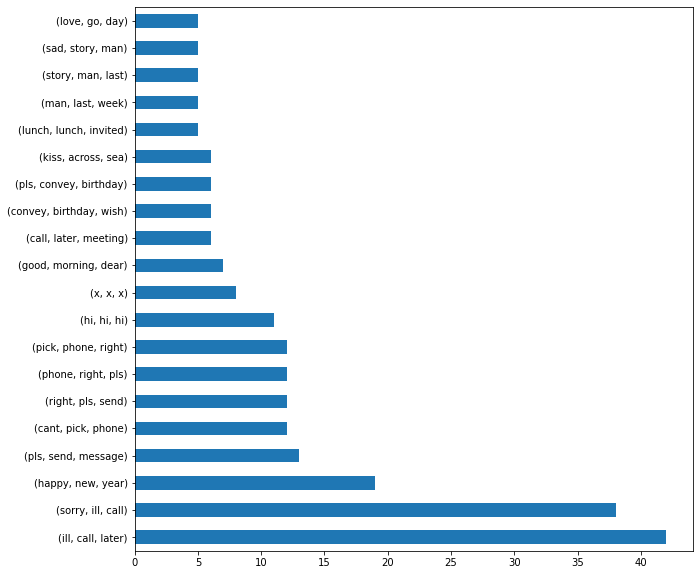

In [20]:
plt.figure(figsize=(10,10))
make_bigrams(ham_corpus, n = 3).nlargest(20).plot.barh()

<AxesSubplot:>

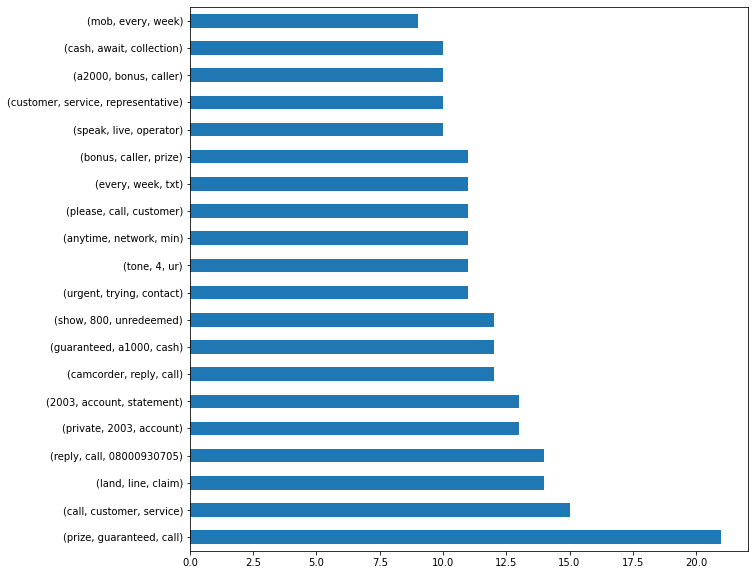

In [33]:
plt.figure(figsize=(10,10))
make_bigrams(spam_corpus, n = 3).nlargest(20).plot.barh()

2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [21]:
blog_df = prepare.make_dataframe(acquire.read_url_or_file_codeup())

Found File


In [22]:
blog_df.sample(2)

,title,content,clean,stemmed,lemmatized
15,learn to code python on 521,according to linkedin the 1 most promising job...,"[according, linkedin, 1, promising, job, data,...","[accord, linkedin, 1, promis, job, data, scien...","[according, linkedin, 1, promising, job, data,..."
21,learn to code python workshop on 423,according to linkedin the 1 most promising job...,"[according, linkedin, 1, promising, job, data,...","[accord, linkedin, 1, promis, job, data, scien...","[according, linkedin, 1, promising, job, data,..."


In [23]:
blog_corpus = ' '.join([' '.join(x) for x in (blog_df['clean'].tolist())]).split()
blog_corpus_lemma = ' '.join([' '.join(x) for x in (blog_df['lemmatized'].tolist())]).split()

In [24]:
blog_corpus_freq = pd.Series(blog_corpus).value_counts()

In [25]:
blog_lemma_freq = pd.Series(blog_corpus_lemma).value_counts()

<AxesSubplot:>

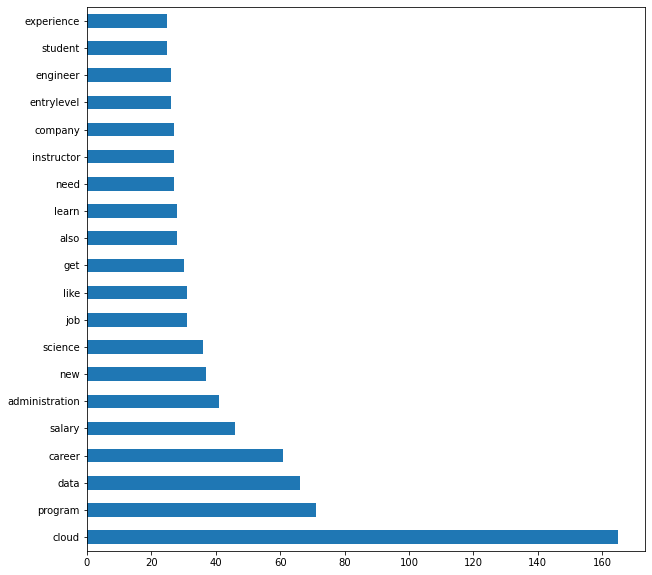

In [26]:
#blog is pushing the cloud academy
plt.figure(figsize=(10,10))
blog_lemma_freq.nlargest(20).plot.barh()

<AxesSubplot:>

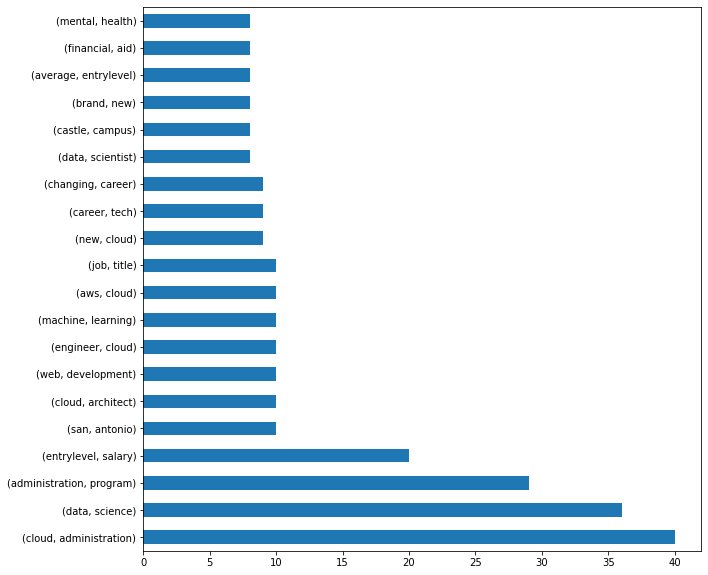

In [27]:
#blog is pushing the cloud admin and data science
plt.figure(figsize=(10,10))
make_bigrams(blog_corpus_lemma).nlargest(20).plot.barh()

3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

In [32]:
news_df = prepare.make_dataframe(acquire.read_url_or_file_inshort())
news_df

Found File


,title,content,clean,stemmed,lemmatized
0,rupee drops 9 paise to close at alltime low of...,the rupee declined by 9 paise to close at a ne...,"[rupee, declined, 9, paise, close, new, record...","[rupe, declin, 9, pais, close, new, record, lo...","[rupee, declined, 9, paisa, close, new, record..."
1,rupee edges closer to 80 per us dollar opens a...,the rupee on friday opened at a record low of ...,"[rupee, friday, opened, record, low, 7994, us,...","[rupe, friday, open, record, low, 7994, us, do...","[rupee, friday, opened, record, low, 7994, u, ..."
2,will prove our position in court we believe w...,following a lawsuit against tesla ceo elon mus...,"[following, lawsuit, tesla, ceo, elon, musk, 4...","[follow, lawsuit, tesla, ceo, elon, musk, 44, ...","[following, lawsuit, tesla, ceo, elon, musk, 4..."
3,musk accused lawyers of causing trouble by see...,in its lawsuit against tesla ceo elon musk twi...,"[lawsuit, tesla, ceo, elon, musk, twitter, sha...","[lawsuit, tesla, ceo, elon, musk, twitter, sha...","[lawsuit, tesla, ceo, elon, musk, twitter, sha..."
4,like all firms we are not immune to economic h...,in an internal memo to the staff google ceo su...,"[internal, memo, staff, google, ceo, sundar, p...","[intern, memo, staff, googl, ceo, sundar, pich...","[internal, memo, staff, google, ceo, sundar, p..."
...,...,...,...,...,...
95,john special ops director shivam team up for a...,shivam nair who helmed special ops and naam sh...,"[shivam, nair, helmed, special, ops, naam, sha...","[shivam, nair, helm, special, op, naam, shaban...","[shivam, nair, helmed, special, ops, naam, sha..."
96,chup is a commercial thriller will release in ...,director r balki has said his upcoming film ch...,"[director, r, balki, said, upcoming, film, chu...","[director, r, balki, said, upcom, film, chup, ...","[director, r, balki, said, upcoming, film, chu..."
97,hed keep telling alia and me go and get marrie...,discussing his late father and actor rishi kap...,"[discussing, late, father, actor, rishi, kapoo...","[discuss, late, father, actor, rishi, kapoor, ...","[discussing, late, father, actor, rishi, kapoo..."
98,tara to make singing debut in ek villain song ...,actress tara sutaria is all set to make her si...,"[actress, tara, sutaria, set, make, singing, d...","[actress, tara, sutaria, set, make, sing, debu...","[actress, tara, sutaria, set, make, singing, d..."


In [38]:
news_corpus = ' '.join([' '.join(x) for x in (news_df['clean'].tolist())]).split()
news_corpus_lemma = ' '.join([' '.join(x) for x in (news_df['lemmatized'].tolist())]).split()

In [40]:
news_corpus_freq = pd.Series(news_corpus).value_counts()
news_lemma_freq = pd.Series(news_corpus_lemma).value_counts()

<AxesSubplot:>

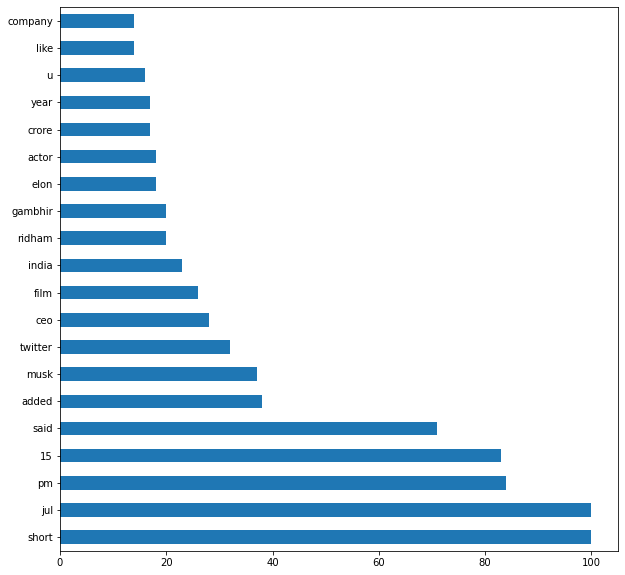

In [41]:
#blog is pushing the cloud academy
plt.figure(figsize=(10,10))
news_lemma_freq.nlargest(20).plot.barh()

<AxesSubplot:>

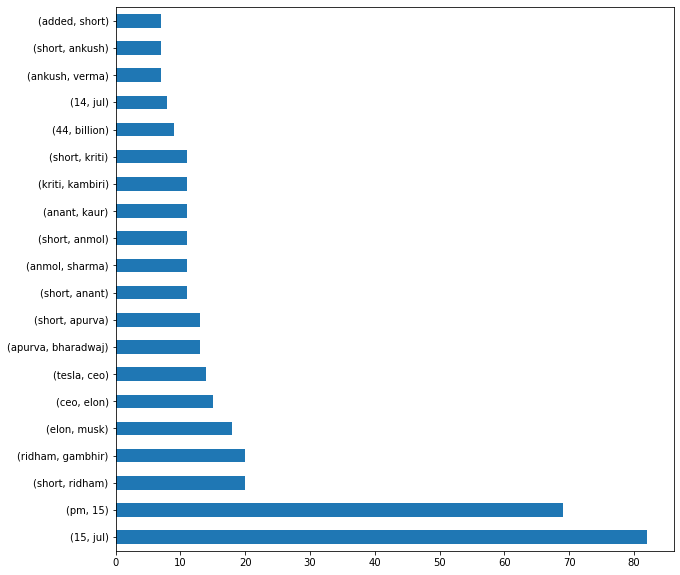

In [42]:
#blog is pushing the cloud admin and data science
plt.figure(figsize=(10,10))
make_bigrams(news_corpus_lemma).nlargest(20).plot.barh()

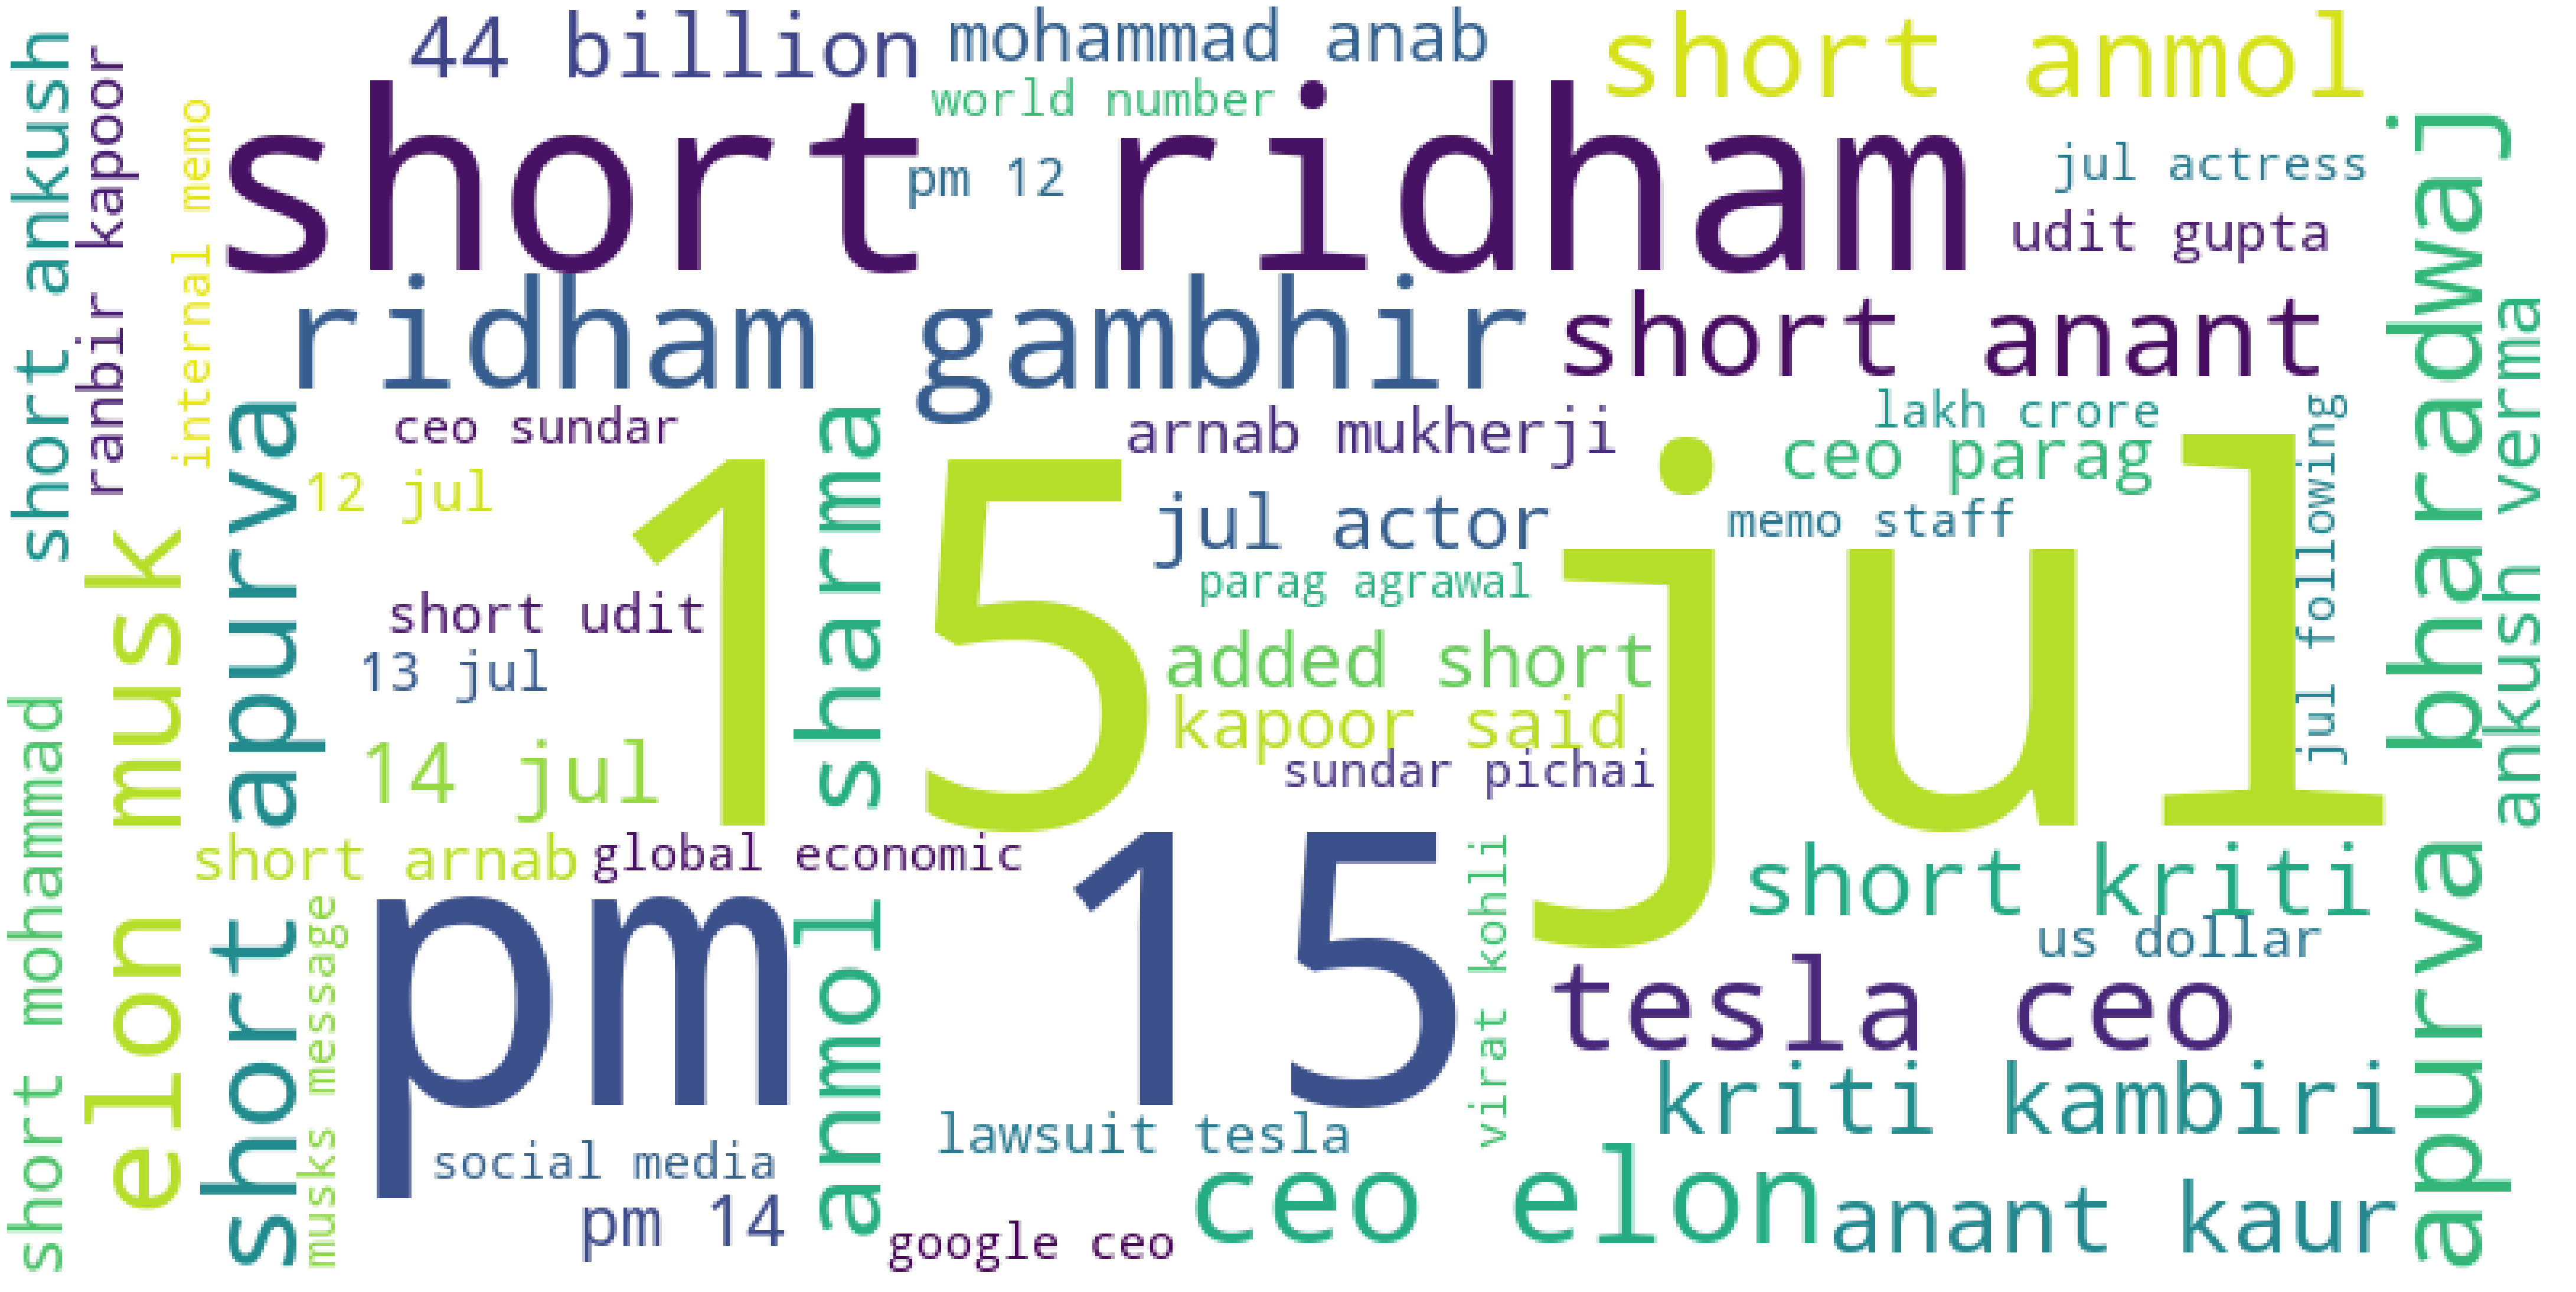

In [43]:
make_bigram_cloud(make_bigrams(news_corpus, n = 2), top = 50)